In [1]:
## Imports & Setup
#------------------# 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import copy
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [27]:
## Load, trim, encode, split dataset

# Identify features for removal, normalization, or encoding
rm_features = ["artists", "id", "name", "year", "release_date"]
norm_features = ["loudness", "popularity", "tempo", "duration_ms"]
categorical_features = ["key"]

# Load data into df
filepath = "../data/spotifyarxiv/data.csv"
df = pd.read_csv(filepath)
#df = df[:1000]
df_ref = df.copy()
target = 'popularity'

# remove unwanted features
for f in rm_features: df.pop(f)
    
# one-hot the categorical "key" feature
keys = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
key_map = {}

for i in range(0, len(keys)): key_map[i] = keys[i]
    
df['key'] = df['key'].map(key_map)
df = pd.get_dummies(df, prefix='', prefix_sep='')
df_ref.shape

(169909, 19)

In [17]:
# split df into training and testing sets
train, test = train_test_split(df, test_size=0.2)

# create stat summary of training set, for reference and normalization
train_labels, test_labels = train.pop(target), test.pop(target)

train_stats = train.describe().transpose()

In [18]:
# define z-score normalization method using train_stats
def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']
normalized_train = normalize(train)
normalized_test = normalize(test)

In [19]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train.keys())]),
        keras.layers.Dense(1)
    ])
    
    model.compile(
        loss='mae', 
        optimizer=tf.keras.optimizers.Adam(lr=0.001),
        metrics=['mae', 'mse'])
   
    return model
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1600      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [20]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
EPOCHS = 100

history = model.fit(
    normalized_train, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

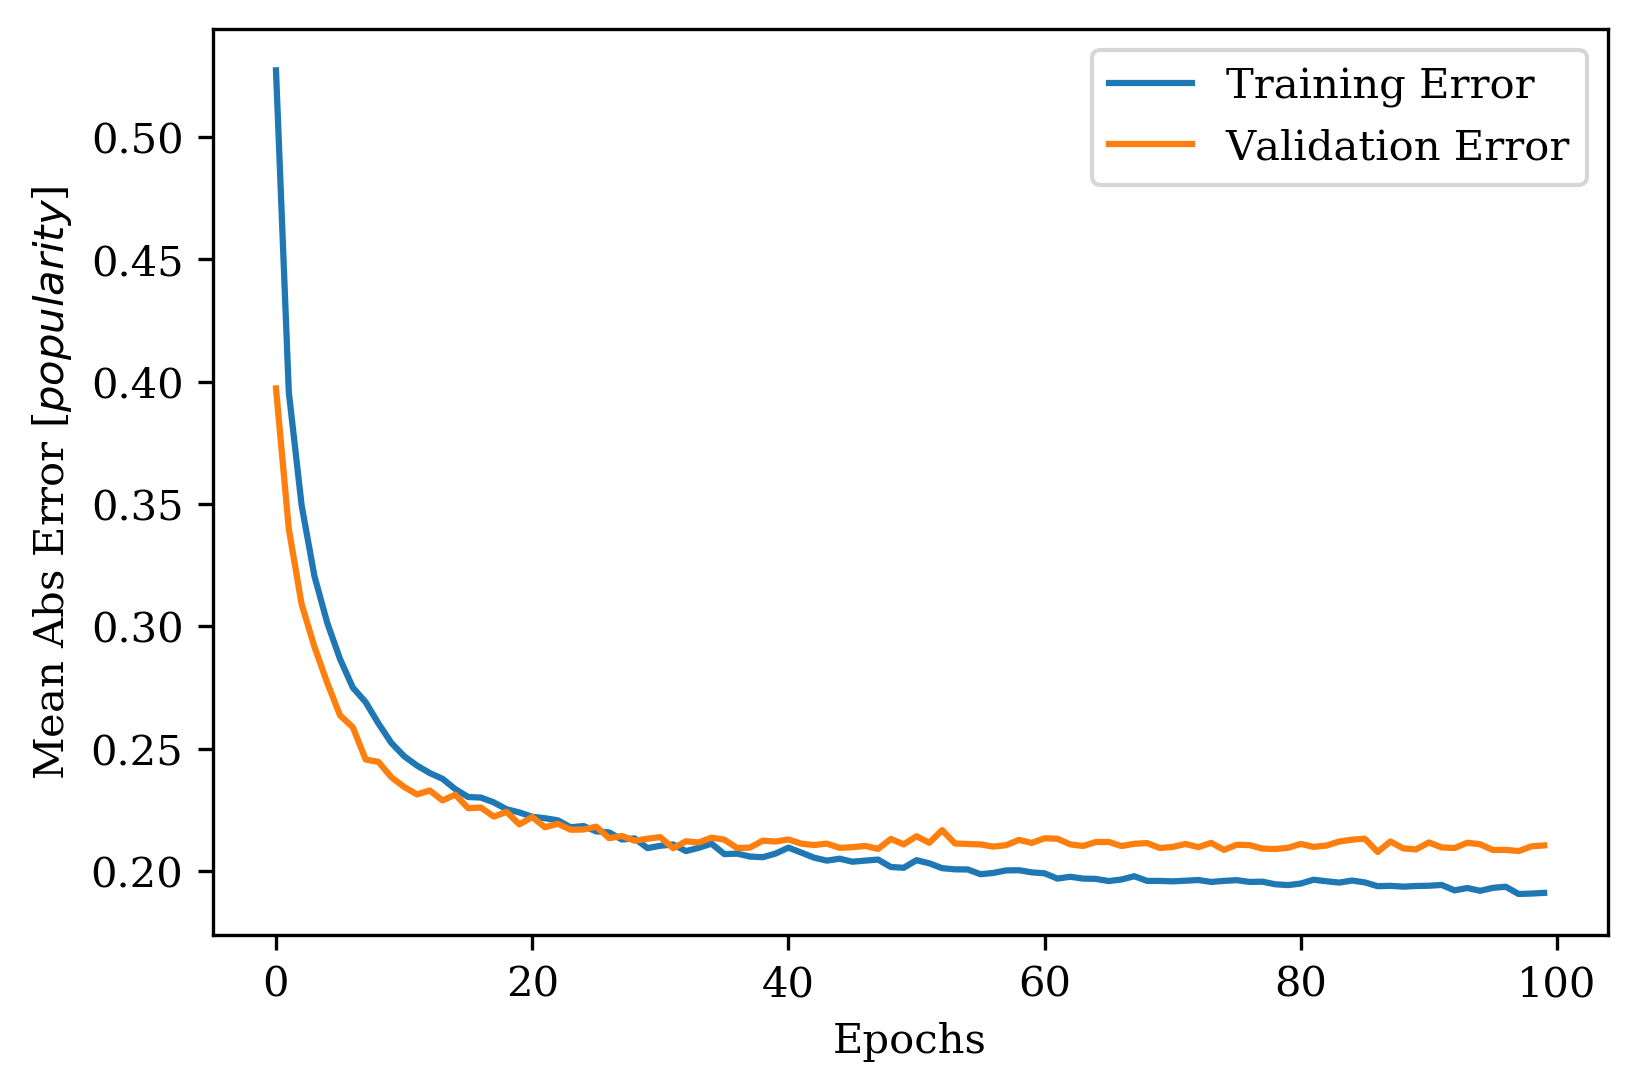

In [28]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Abs Error [$popularity$]')
    plt.plot(hist['epoch'], hist['mae'], label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Validation Error')
    plt.legend()

plot_history(history)

In [22]:
results = model.evaluate(normalized_test, test_labels, batch_size=32)

200/200 [==============================] - 0s 383us/sample - loss: 0.3561 - mae: 0.3561 - mse: 1.1009


regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns)